In [1]:
import torch
import random
import re
import matplotlib.pyplot as plt
import unicodedata
from io import open
import time
import math
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2

    def add_sentence(self, sentence):
        for word in sentence.split(" "):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
lang = Lang("eng")
lang.add_sentence("Hi i m Vova and Danik loh and i loh")
print(lang.index2word)
print(lang.word2count)
print(lang.word2index)
print(lang.n_words)
print(lang)

{0: 'SOS', 1: 'EOS', 2: 'Hi', 3: 'i', 4: 'm', 5: 'Vova', 6: 'and', 7: 'Danik', 8: 'loh'}
{'Hi': 1, 'i': 2, 'm': 1, 'Vova': 1, 'and': 2, 'Danik': 1, 'loh': 2}
{'Hi': 2, 'i': 3, 'm': 4, 'Vova': 5, 'and': 6, 'Danik': 7, 'loh': 8}
9


In [5]:
def unicode_to_ascii(s):
    return "".join(c for c in unicodedata.normalize("NFD", s) if unicodedata.category(c) != "Mn")

def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [7]:
def read_langs(lang1, lang2, reverse=False):
    lines = open(f"{lang1}-{lang2}.txt", encoding="utf-8").read().strip().split("\n")
    pairs = [[normalize_string(s) for s in l.split("\t")] for l in lines]

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [23]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filter_pair(pair, reverse=False):
    which_pair = 1 if reverse else 0
    return len(pair[0].split(" ")) < MAX_LENGTH and len(pair[1].split(" ")) < MAX_LENGTH and pair[which_pair].startswith(eng_prefixes)

def filter_pairs(pairs, reverse=False):
    return [pair for pair in pairs if filter_pair(pair, reverse)]

In [24]:
def prepare_data(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = read_langs(lang1, lang2, reverse)
    print(f"Read {len(pairs)} sentence pairs")
    pairs = filter_pairs(pairs, reverse)
    print(f"Trimmed to {len(pairs)} sentence pairs")
    print("Counting words...")
    for pair in pairs:
        input_lang.add_sentence(pair[0])
        output_lang.add_sentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepare_data("eng", "fra")
print(random.choice(pairs))

Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
eng 2803
fra 4345
['we re housesitting .', 'nous gardons la maison .']


# **Creating Model**

In [29]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size

        self.embeddings = torch.nn.Embedding(self.input_size, self.hidden_size)
        self.gru = torch.nn.GRU(self.hidden_size, self.hidden_size)

    def forward(self, x, hidden):
        x = self.embeddings(x).view(1, 1, -1)
        x, hidden = self.gru(x, hidden)
        return x, hidden

    def init_hidden(self):
        return torch.randn(1, 1, self.hidden_size, device=device)

In [30]:
class DecoderAttention(torch.nn.Module):
    def __init__(self, output_size, hidden_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super().__init__()

        self.output_size = output_size
        self.hidden_size = hidden_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embeddings = torch.nn.Embedding(self.output_size, self.hidden_size)
        self.attention = torch.nn.Linear(self.hidden_size * 2, self.max_length)
        self.attention_combine = torch.nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = torch.nn.Dropout(self.dropout_p)

        self.gru = torch.nn.GRU(self.hidden_size, self.hidden_size)
        self.out = torch.nn.Linear(self.hidden_size, self.output_size)
        self.softmax = torch.nn.Softmax(dim=1)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)
        self.relu = torch.nn.ReLU()

    def forward(self, inp, hidden, encoder_outputs):
        embedded = self.embeddings(inp).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attention_weights = self.softmax(
            self.attention(torch.cat((embedded[0], hidden[0]), 1))
        )
        attention_applied = torch.bmm(attention_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attention_applied[0]), 1)
        output = self.attention_combine(output).unsqueeze(0)
        output = self.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.log_softmax(self.out(output[0]))
        return output, hidden, attention_weights

# **Training**

In [31]:
def indexes_from_sentences(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(" ")]

def tensor_from_sentences(lang, sentence):
    indexes = indexes_from_sentences(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device)

def tensor_from_pair(pair):
    input_tensor = tensor_from_sentences(input_lang, pair[0])
    target_tensor = tensor_from_sentences(output_lang, pair[1])
    return input_tensor, target_tensor

In [32]:
input_tensor, target_tensor = tensor_from_pair(random.choice(pairs))
input_tensor, target_tensor

(tensor([129,  78, 147, 487, 284,   4,   1], device='cuda:0'),
 tensor([118, 245, 214, 246, 489,   5,   1], device='cuda:0'))

In [33]:
teacher_forcing_ration = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optim, decoder_optim, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.init_hidden()

    encoder_optim.zero_grad()
    decoder_optim.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for idx in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[idx], encoder_hidden)
        encoder_outputs[idx] = encoder_output[0, 0]
    
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ration else False

    if use_teacher_forcing: # With Teacher Forcing
        for idx in range(target_length):
            decoder_output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[idx].unsqueeze(0))
            decoder_input = target_tensor[idx]
    else: # Without Teacher Forcing
        for idx in range(target_length):
            decoder_output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)
            top_value, top_index = decoder_output.topk(1)
            decoder_input = top_index.squeeze().detach()
            loss += criterion(decoder_output, target_tensor[idx].unsqueeze(0))
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optim.step()
    decoder_optim.step()

    return loss.item() / target_length

In [34]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

In [39]:
def train_iters(encoder, decoder, n_iters):
    start = time.time()

    encoder.to(device)
    decoder.to(device)

    losses = []
    total_loss = 0

    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=0.001)
    criterion = torch.nn.NLLLoss()
    training_pairs = [tensor_from_pair(random.choice(pairs)) for _ in range(n_iters)]

    for idx in range(1, n_iters + 1):
        training_pair = training_pairs[idx - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        total_loss += loss

        if idx % 1000 == 0:
            loss_avg = total_loss / 1000
            total_loss = 0
            losses.append(loss_avg)
            t = time_since(start, idx / n_iters)
            print(f"Iter {idx} / {n_iters}\nLoss {loss_avg}\nTime {t}")

        plt.plot(losses)

In [36]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensor_from_sentences(input_lang, sentence)
        input_size = input_tensor.size(0)
        encoder_hidden = encoder.init_hidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for idx in range(input_size):
            encoder_output, encoder_hidden = encoder(input_tensor[idx].unsqueeze(0), encoder_hidden)
            encoder_outputs[idx] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_attentions = torch.zeros(max_length, max_length, device=device)

        decoder_hidden = encoder_hidden
        decoded_words = []

        for idx in range(max_length):
            decoder_output, decoder_hidden, decoder_attention_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[idx] = decoder_attention_weights.data
            top_value, top_index = decoder_output.topk(1)
            if top_index.item() == EOS_token:
                break
            else:
                decoded_words.append(output_lang.index2word[top_index.item()])
            decoder_input = top_index.squeeze().detach()
        return decoded_words

In [37]:
def evaluate_randomly(encoder, decoder, n=10):
    for idx in range(n):
        pair = random.choice(pairs)
        print(f"Eng: {pair[0]}")
        print(f"Real\nFra: {pair[1]}")
        predicted_words = evaluate(encoder, decoder, pair[0])
        predicted_sentence = " ".join(predicted_words)
        print(f"Predicted\nFra: {predicted_sentence}")
        print("-" * 20)

Iter 1000 / 20000
Loss 1.4870882198742466
Time 0m 29s (- 9m 18s)
Iter 2000 / 20000
Loss 1.6841315216683683
Time 0m 55s (- 8m 17s)
Iter 3000 / 20000
Loss 1.7497583538720782
Time 1m 21s (- 7m 42s)
Iter 4000 / 20000
Loss 1.630925012983571
Time 1m 47s (- 7m 10s)
Iter 5000 / 20000
Loss 1.7044804478715327
Time 2m 13s (- 6m 40s)
Iter 6000 / 20000
Loss 1.6316950645576276
Time 2m 39s (- 6m 11s)
Iter 7000 / 20000
Loss 1.6494741248351117
Time 3m 5s (- 5m 43s)
Iter 8000 / 20000
Loss 1.5456483150770732
Time 3m 31s (- 5m 17s)
Iter 9000 / 20000
Loss 1.6190574551910644
Time 3m 58s (- 4m 51s)
Iter 10000 / 20000
Loss 1.4921178265895507
Time 4m 24s (- 4m 24s)
Iter 11000 / 20000
Loss 1.4675209128153817
Time 4m 50s (- 3m 57s)
Iter 12000 / 20000
Loss 1.5199660112156272
Time 5m 16s (- 3m 31s)
Iter 13000 / 20000
Loss 1.506842292833188
Time 5m 43s (- 3m 4s)
Iter 14000 / 20000
Loss 1.5315754655768599
Time 6m 9s (- 2m 38s)
Iter 15000 / 20000
Loss 1.409432038872416
Time 6m 35s (- 2m 11s)
Iter 16000 / 20000
Loss 1

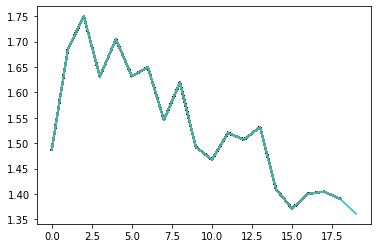

In [48]:
HIDDEN_SIZE = 256

encoder = Encoder(input_size=input_lang.n_words, hidden_size=HIDDEN_SIZE)
decoder = DecoderAttention(output_size=output_lang.n_words, hidden_size=HIDDEN_SIZE)

encoder.load_state_dict(torch.load("encoder_w.pth"))
decoder.load_state_dict(torch.load("decoder_w.pth"))

train_iters(encoder, decoder, 20000)

In [50]:
torch.save(encoder.state_dict(), "encoder_w.pth")
torch.save(decoder.state_dict(), "encoder_w.pth")

In [42]:
encoder = Encoder(input_size=input_lang.n_words, hidden_size=HIDDEN_SIZE)
decoder = DecoderAttention(output_size=output_lang.n_words, hidden_size=HIDDEN_SIZE)

encoder.load_state_dict(torch.load("encoder_w.pth"))
decoder.load_state_dict(torch.load("decoder_w.pth"))

encoder.to(device)
decoder.to(device)

DecoderAttention(
  (embeddings): Embedding(4345, 256)
  (attention): Linear(in_features=512, out_features=10, bias=True)
  (attention_combine): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(256, 256)
  (out): Linear(in_features=256, out_features=4345, bias=True)
  (softmax): Softmax(dim=1)
  (log_softmax): LogSoftmax(dim=1)
  (relu): ReLU()
)

In [43]:
evaluate_randomly(encoder, decoder)

Eng: i m not so sure .
Real
Fra: je n en suis pas si sure !
Predicted
Fra: je n en suis pas si je .
--------------------
Eng: they are loyal to their master .
Real
Fra: ils sont loyaux envers leur maitre .
Predicted
Fra: ils sont des prete a leur . .
--------------------
Eng: you are lying .
Real
Fra: vous mentez .
Predicted
Fra: vous etes en train de mentir .
--------------------
Eng: they re small .
Real
Fra: elles sont petites .
Predicted
Fra: elles sont en train de parler .
--------------------
Eng: you are too critical of others shortcomings .
Real
Fra: tu es trop critique des defauts des autres .
Predicted
Fra: tu es trop critique de de critique des autres .
--------------------
Eng: we re sensitive .
Real
Fra: nous sommes sensibles .
Predicted
Fra: nous sommes sensible .
--------------------
Eng: you re demented .
Real
Fra: vous etes fous .
Predicted
Fra: tu es fous .
--------------------
Eng: i am afraid that you will get lost .
Real
Fra: je crains que tu te perdes .
Predicted
